# Croatia: Population Trend 1990 - 2018

* [Presentation (slide-deck)](https://github.com/zunicd/Population-Trend-Croatia-2018/blob/master/Croatia%20-%20Population%20Trend%201990%20-%202018.pdf)


**Data Source:** [World Development Indicators, The World Bank](https://datacatalog.worldbank.org/dataset/world-development-indicators)

**File:** The raw file, *WDIData.csv*, from downloaded archive was slightly transformed, resulted *in WDI_Indicators.csv*. Check this [notebook](https://github.com/zunicd/Population-Trend-Croatia-2018/blob/master/Transforming%20World%20Development%20Indicators.ipynb).

## Motivation

Being myself an emigrant from Croatia, I am interested in Croatian migration trends in last few decades. As one of ex-Yugoslav republics, in the last 30 years Croatia faced three events that could have an impact to its population:

1. <strong style="color:Royalblue">Yugoslav wars (1991 – 1995),</strong> led to the breakup of Yugoslavia

2. <strong style="color:Royalblue">Great Recession (2008),</strong> with follow-up recessions shaking Croatia until 2014

3. <strong style="color:Royalblue">Integration to the EU (2013),</strong> Croatians acquired right to move and reside freely in other EU member states

This research is very personal to me. In addition to me emigrating (event #1) in 1995, my younger nephew emigrated in 2018 (event #3). So, let’s start crunching the data.


## Library Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium
import seaborn as sns
%matplotlib inline

# Tick locating and formatting 
import matplotlib.ticker as tkr

## Dataframe Preparation

In [2]:
# read the file
df = pd.read_csv('./Data/world-development-indicators/WDI_Indicators.csv')
df.shape

(7998575, 6)

In [3]:
# display number of unique indicators
df.IndicatorName.nunique()

1599

In [4]:
df.head(2)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,134.772341
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,88.061110


### Keep only 3 needed indicators

We will keep only the following three indicators:
 * Population, total
 * Net migration
 * GDP per capita (constant 2010 US$)

In [5]:
# define Pandas series for 3 inidicators
inds = pd.Series(['Population, total','Net migration','GDP per capita (constant 2010 US$)'])
inds

0                     Population, total
1                         Net migration
2    GDP per capita (constant 2010 US$)
dtype: object

In [6]:
# indicators mask
maski = df['IndicatorName'].isin(inds)
# create new dataframe with 3 indicators only
df3i = df[maski].copy().reset_index(drop=True)
df3i.head(2)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Population, total",SP.POP.TOTL,1960,92197753.0
1,Caribbean small states,CSS,"Population, total",SP.POP.TOTL,1960,4194710.0


In [7]:
# display shape
print(df3i.shape)
# display number of unique indicators
print(df3i.IndicatorName.nunique())

(29913, 6)
3


**Reshape dataframe to have 3 filtered indicators as columns**

In [8]:
# reshape dataframe to have 3 indicators as columns
data = df3i.pivot_table(values='Value',columns=['IndicatorName'], index=['CountryName','CountryCode','Year'])
data.head(2)

IndicatorName                 GDP per capita (constant 2010 US$)  \
CountryName CountryCode Year                                       
Afghanistan AFG         1960                                 NaN   
                        1961                                 NaN   

IndicatorName                 Net migration  Population, total  
CountryName CountryCode Year                                    
Afghanistan AFG         1960            NaN          8996973.0  
                        1961            NaN          9169410.0

In [9]:
data.columns

Index(['GDP per capita (constant 2010 US$)', 'Net migration',
       'Population, total'],
      dtype='object', name='IndicatorName')

In [10]:
# remove the name of columns axis
data.columns.name=None
# add all 3 indexes as columns and reset index to default integer index
data.reset_index(inplace=True)
data.head(2)

,CountryName,CountryCode,Year,GDP per capita (constant 2010 US$),Net migration,"Population, total"
0,Afghanistan,AFG,1960,NaN,NaN,8996973.0
1,Afghanistan,AFG,1961,NaN,NaN,9169410.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15412 entries, 0 to 15411
Data columns (total 6 columns):
CountryName                           15412 non-null object
CountryCode                           15412 non-null object
Year                                  15412 non-null int64
GDP per capita (constant 2010 US$)    11636 non-null float64
Net migration                         2868 non-null float64
Population, total                     15409 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 722.5+ KB


In [12]:
# Check the number of countries
data.CountryName.nunique()

263

**Save the dataframe to the `csv` file:**

This version of dataframe is good to be used in Tableau Public so we will save it.

In [13]:
# Uncomment below line to save dataframe for Tableau use
#data.to_csv('./Data/world-development-indicators/WDI_Indicators-Tableau.csv', index=False)

**Ex-Yugoslavia countries**

In [14]:
yugo_cntr = pd.Series(['Croatia','Slovenia','Serbia','Montenegro','North Macedonia','Bosnia and Herzegovina','Kosovo'])
yugo_cntr

0                   Croatia
1                  Slovenia
2                    Serbia
3                Montenegro
4           North Macedonia
5    Bosnia and Herzegovina
6                    Kosovo
dtype: object

In [15]:
# mask for ex-Yugoslavia countries
masky = data['CountryName'].isin(yugo_cntr)
# new dataframe
yugo = data[masky].copy()
yugo.head(2)

,CountryName,CountryCode,Year,GDP per capita (constant 2010 US$),Net migration,"Population, total"
1475,Bosnia and Herzegovina,BIH,1960,NaN,NaN,3225668.0
1476,Bosnia and Herzegovina,BIH,1961,NaN,NaN,3288603.0


In [16]:
yugo.shape

(383, 6)

In [17]:
# we will use indicator names for plotting 
cols = yugo.columns.tolist()
cols

['CountryName',
 'CountryCode',
 'Year',
 'GDP per capita (constant 2010 US$)',
 'Net migration',
 'Population, total']

In [18]:
# make shorter column names
yugo = yugo.rename(columns={'GDP per capita (constant 2010 US$)':'GDPperCapita',
                     'Net migration':'NetMigration',
                     'Population, total':'PopulationTotal'})
yugo.head(2)

,CountryName,CountryCode,Year,GDPperCapita,NetMigration,PopulationTotal
1475,Bosnia and Herzegovina,BIH,1960,NaN,NaN,3225668.0
1476,Bosnia and Herzegovina,BIH,1961,NaN,NaN,3288603.0


In [19]:
yugo.count()

CountryName        383
CountryCode        383
Year               383
GDPperCapita       172
NetMigration        66
PopulationTotal    383
dtype: int64


**Work with "Population, total"**

The same time frame for all countries is 1990 - 2018

In [20]:
# population dataframe
pop_yugo = yugo.drop(['GDPperCapita','NetMigration'],axis=1)
# keep data after 1989
pop_yugo90 = pop_yugo[pop_yugo['Year'] > 1989]
pop_yugo90.head(2)

,CountryName,CountryCode,Year,PopulationTotal
1505,Bosnia and Herzegovina,BIH,1990,4463423.0
1506,Bosnia and Herzegovina,BIH,1991,4369319.0


## Display population trend (growth/decline) for all countries##
 
 

**Transform the dataframe**

In [21]:
# reshape/pivot dataframe
pop_y = pop_yugo90.pivot_table(values='PopulationTotal',index=('CountryName','CountryCode'),columns='Year')
pop_y.head(2)

,Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
CountryName,CountryCode,,,,,,,,,,,,,,,,,,,,,
Bosnia and Herzegovina,BIH,4463423.0,4369319.0,4233676.0,4078937.0,3936524.0,3829050.0,3764425.0,3736070.0,3734337.0,3743354.0,...,3735938.0,3705472.0,3661175.0,3604972.0,3542605.0,3482104.0,3429361.0,3386267.0,3351527.0,3323929.0
Croatia,HRV,4777368.0,4689022.0,4575818.0,4600463.0,4652024.0,4620030.0,4557097.0,4534920.0,4532135.0,4512597.0,...,4305181.0,4295427.0,4280622.0,4267558.0,4255689.0,4238389.0,4203604.0,4174349.0,4124531.0,4089400.0


In [22]:
# remove name of columns and reset index
pop_y.columns.name = None
pop_y.reset_index(inplace=True)
pop_y.head(2)

,CountryName,CountryCode,1990,1991,1992,1993,1994,1995,1996,1997,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Bosnia and Herzegovina,BIH,4463423.0,4369319.0,4233676.0,4078937.0,3936524.0,3829050.0,3764425.0,3736070.0,...,3735938.0,3705472.0,3661175.0,3604972.0,3542605.0,3482104.0,3429361.0,3386267.0,3351527.0,3323929.0
1,Croatia,HRV,4777368.0,4689022.0,4575818.0,4600463.0,4652024.0,4620030.0,4557097.0,4534920.0,...,4305181.0,4295427.0,4280622.0,4267558.0,4255689.0,4238389.0,4203604.0,4174349.0,4124531.0,4089400.0


**Calculate population growth/decline for the time frame 1990 - 2018**




Formula:


$\displaystyle PR = \frac{(V_{Present} - V_{Past})}{V_{Past}} * 100$    

where

$PR$ = Percent Rate; $V_{Present}$ = Present Value; $V_{Past}$ = Past Value

***

In [23]:
# calculate percent rate and add new column
pop_y['Population Growth (%)'] = round((((pop_y[2018] - pop_y[1990]) / pop_y[1990]) * 100),2)
pop_y

,CountryName,CountryCode,1990,1991,1992,1993,1994,1995,1996,1997,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Population Growth (%)
0,Bosnia and Herzegovina,BIH,4463423.0,4369319.0,4233676.0,4078937.0,3936524.0,3829050.0,3764425.0,3736070.0,...,3705472.0,3661175.0,3604972.0,3542605.0,3482104.0,3429361.0,3386267.0,3351527.0,3323929.0,-25.53
1,Croatia,HRV,4777368.0,4689022.0,4575818.0,4600463.0,4652024.0,4620030.0,4557097.0,4534920.0,...,4295427.0,4280622.0,4267558.0,4255689.0,4238389.0,4203604.0,4174349.0,4124531.0,4089400.0,-14.40
2,Kosovo,XKX,1862000.0,1898000.0,1932000.0,1965000.0,1997000.0,2029000.0,2059000.0,2086000.0,...,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0,1845300.0,-0.90
3,Montenegro,MNE,606372.0,607105.0,608516.0,610170.0,611389.0,611712.0,611003.0,609520.0,...,619428.0,620079.0,620601.0,621207.0,621810.0,622159.0,622303.0,622373.0,622345.0,2.63
4,North Macedonia,MKD,1996228.0,1993302.0,1988659.0,1984028.0,1981703.0,1983252.0,1989443.0,1999598.0,...,2070741.0,2072487.0,2074278.0,2076067.0,2077775.0,2079328.0,2080745.0,2081996.0,2082958.0,4.34
5,Serbia,SRB,7586000.0,7595636.0,7646424.0,7699307.0,7734639.0,7625357.0,7617794.0,7596501.0,...,7291436.0,7234099.0,7199077.0,7164132.0,7130576.0,7095383.0,7058322.0,7020858.0,6982084.0,-7.96
6,Slovenia,SVN,1998161.0,1999429.0,1996498.0,1991746.0,1989443.0,1989872.0,1988628.0,1985956.0,...,2048583.0,2052843.0,2057159.0,2059953.0,2061980.0,2063531.0,2065042.0,2066388.0,2067372.0,3.46


### Setup data for plotting. 

Create the data frame with just country codes and population growth values.


In [24]:
plot_data = pop_y[['CountryCode','Population Growth (%)']]
plot_data

,CountryCode,Population Growth (%)
0,BIH,-25.53
1,HRV,-14.40
2,XKX,-0.90
3,MNE,2.63
4,MKD,4.34
5,SRB,-7.96
6,SVN,3.46


**Country coordinates for plotting**

The GeoJSON file for ex-Yugoslavia countries was built on this site: https://geojson-maps.ash.ms/.

The country code for Kosovo, XKX, was used to manually update the `sov_a3` code in the GeoJSON file.

In [25]:
country_geo = './Data/custom_geo_high.json'

**Setup folium and choropleth maps**

In [26]:
# create a plain map of ex-Yugoslavia
yugo_map = folium.Map(
    location=[43.84864, 18.35644],
    tiles='openstreetmap',
    zoom_start=7
)

# generate choropleth map using the population growth of each country from 1990 to 2018
folium.Choropleth(
    geo_data=country_geo,
    data=plot_data,
    columns=['CountryCode','Population Growth (%)'],
    key_on='feature.properties.sov_a3',
    # fill_color='YlOrRd',
    fill_color='Spectral',
    bins=11,
    fill_opacity=0.6,
    line_opacity=0.5,
    legend_name='Population Growth (%)'
).add_to(yugo_map)

folium.LayerControl().add_to(yugo_map)


In [27]:
# Create Folium plot
yugo_map.save('./Figures/yugo_pop_growth.html')

Negative population growth values mean population decline.

In the next steps we will reserach data for Croatia (14.40 % population decline since 1990).

In [28]:
# Import the Folium interactive html file
from IPython.display import IFrame
IFrame(src='./Figures/yugo_pop_growth.html', width=900, height=800)

### Plot "Population, total" for Bosnia and Herzegovina and Croatia (1990 - 2018)

Let's plot "Population, total" for two countries with the highest population decline: **Bosnia and Herzegovina** (25.53%) and **Croatia** (14.40%)

In [29]:
pop_yugo90.head(2)

,CountryName,CountryCode,Year,PopulationTotal
1505,Bosnia and Herzegovina,BIH,1990,4463423.0
1506,Bosnia and Herzegovina,BIH,1991,4369319.0


In [30]:
# limit dataframe to Bosnia and Herzegovina and Croatia
pop_bihc = pop_yugo90[pop_yugo90['CountryName'].isin(['Croatia','Bosnia and Herzegovina'])]
# drop country code
pop_bhc = pop_bihc.drop(['CountryCode'],axis=1)
print(pop_bhc['CountryName'].unique())
pop_bhc.head(2)

['Bosnia and Herzegovina' 'Croatia']


,CountryName,Year,PopulationTotal
1505,Bosnia and Herzegovina,1990,4463423.0
1506,Bosnia and Herzegovina,1991,4369319.0


In [31]:
# reshape/pivot dataframe
pop_bhc = pop_bhc.pivot_table(values='PopulationTotal',columns=('CountryName'),index='Year')
pop_bhc.head(2)

CountryName,Bosnia and Herzegovina,Croatia
Year,,
1990,4463423.0,4777368.0
1991,4369319.0,4689022.0


In [32]:
# Remove column name "CountryName"
pop_bhc.columns.name = None
# Insert index "Year" as column and reset index to default integer index
pop_bhc.reset_index(inplace=True)
pop_bhc.head(2)

,Year,Bosnia and Herzegovina,Croatia
0,1990,4463423.0,4777368.0
1,1991,4369319.0,4689022.0


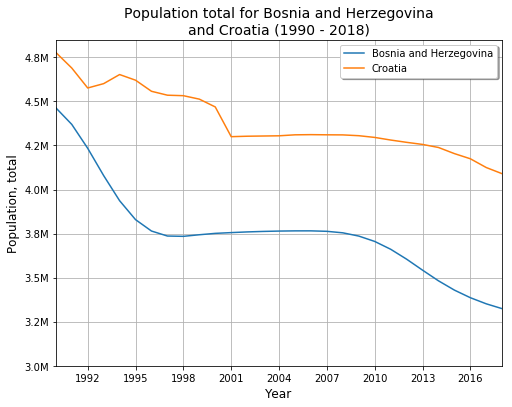

In [33]:
# plt.figure() # create figure

ax = pop_bhc.plot(x='Year',kind='line',figsize=(8,6))
ax.legend(shadow=True)

ax.set_title ('Population total for Bosnia and Herzegovina\nand Croatia (1990 - 2018)',fontsize=14)
ax.set_ylabel(cols[5],fontsize=12)
ax.set_xlabel('Year',fontsize=12)
ax.set_ylim(3000000)

ax.grid(True)

# ensure that x-axis have integer-only tick labels
# and increase number of ticks
ax.xaxis.set_major_locator(tkr.MaxNLocator(integer=True))
# reformat tick labels with million's M and comma separator
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: "{:,.1f}M".format(x*1e-6)))

plt.show()
#plt.savefig("./Figures/population_BIH_HRV.png")

* For both countries population declined during the war and after the Great Recession.

* Slight population incline for Croatia around 1993 could be explained by immigration from Bosnia and Herzegovina

* Population stabilized soon after the war for Bosnia and Herzegovina, and several years later for Croatia


## Display "Net migration" for Croatia



`"Net migration"` data for five countries is available from 1962 - 2017 in 5 years steps. No data for Kosovo, and some data is missing for Serbia.

In [34]:
# migration dataframe for ex-Yugoslavia countries
migr_yugo = yugo.drop(['CountryCode','GDPperCapita','PopulationTotal'],axis=1)
migr_yugo.head()

,CountryName,Year,NetMigration
1475,Bosnia and Herzegovina,1960,NaN
1476,Bosnia and Herzegovina,1961,NaN
1477,Bosnia and Herzegovina,1962,-50002.0
1478,Bosnia and Herzegovina,1963,NaN
1479,Bosnia and Herzegovina,1964,NaN


**Transform the dataframe**

In [35]:
migr_yugo.rename(columns={'CountryName':'Country'}, inplace=True)
migr_yugo.head(2)

,Country,Year,NetMigration
1475,Bosnia and Herzegovina,1960,NaN
1476,Bosnia and Herzegovina,1961,NaN


In [36]:
# reshape/pivot dataframe
migr_y = migr_yugo.pivot_table(values='NetMigration',columns='Country',index='Year')
migr_y.head(2)

Country,Bosnia and Herzegovina,Croatia,Montenegro,North Macedonia,Serbia,Slovenia
Year,,,,,,
1962,-50002.0,1854.0,-2001.0,-40940.0,NaN,-22059.0
1967,-96958.0,-1225.0,-53773.0,-28981.0,NaN,-14950.0


**Plot net migration for all ex-Yugoslavia countries**

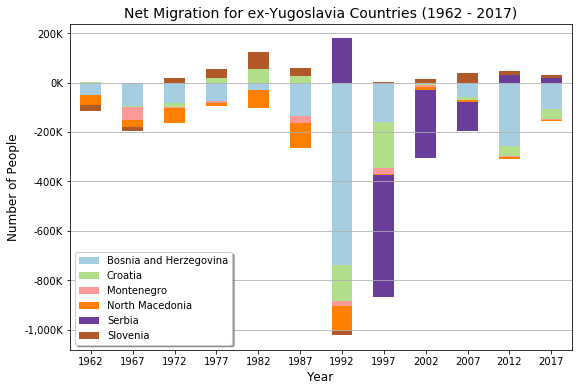

In [37]:
ax = migr_y.plot(kind='bar', stacked=True, figsize=(9, 6), colormap='Paired')
ax.legend(shadow=True)

ax.set_title ('Net Migration for ex-Yugoslavia Countries (1962 - 2017)',fontsize=14)
ax.set_ylabel('Number of People',fontsize=12)
ax.set_xlabel('Year',fontsize=12)
ax.xaxis.set_tick_params(rotation=0)
ax.yaxis.grid(True)

# reformat tick labels with thousand's K and comma separator
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: "{:,.0f}K".format(x*1e-3)))

plt.show()
#plt.savefig("./Figures/migration_bars_all.png")

* During the war the highest emigration was from Bosnia and Herzegovina. Much less from Croatia and North Macedonia.

* During the same period we see high immigration to Serbia.

* After the war the highest emigration was from Serbia. People were still emigrating from Croatia and Bosnia and Herzegovina.

* The Great Recession mostly impacted Bosnia and Herzegovina and Croatia. Emigration was slowing down for Bosnia and Herzegovina but still slightly increasing for Croatia.

Let's now concentrate on Croatia only.

**Plot Net Migration for Croatia**

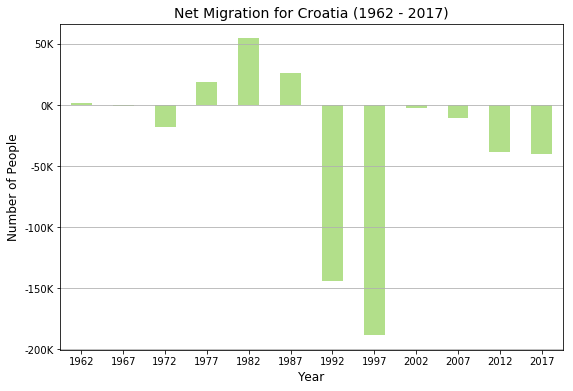

In [38]:
ax = migr_y['Croatia'].plot(kind='bar', figsize=(9, 6),color='#b2df8a')

ax.set_title ('Net Migration for Croatia (1962 - 2017)',fontsize=14)
ax.set_ylabel('Number of People',fontsize=12)
ax.set_xlabel('Year',fontsize=12)
ax.xaxis.set_tick_params(rotation=0)
ax.yaxis.grid(True)

# reformat tick labels with thousand's K and comma separator
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: "{:,.0f}K".format(x*1e-3)))

plt.show()
#plt.savefig("./Figures/migration_bars_HRV.png")

In [39]:
pd.DataFrame(migr_y['Croatia']).T

Year,1962,1967,1972,1977,1982,1987,1992,1997,2002,2007,2012,2017
Croatia,1854.0,-1225.0,-18403.0,18681.0,54369.0,26145.0,-143579.0,-188129.0,-2580.0,-10499.0,-38493.0,-40004.0


* Negative values are **emigration** and positive values are **immigration**. 

* Emigration was high at 90's, during and after the Yugoslav wars. 

* There was a smaller, but still significant, increase in emigration after the Great Recession (2008). 

* The same trend continues in the next step after 2012. That coincides with Croatia joining EU in 2013.


## GDP - Population Relationship for Croatia (1995 - 2018)


GDP data for Croatia exist only from 1995. Because of that, we will limit population data to the same period.

### Prepare GDP dataframes for Croatia

In [40]:
# dataframe for Croatia
cro = yugo[yugo['CountryName'].isin(['Croatia'])]
# drop not needed columns
gdp_cro = cro.drop(['NetMigration','PopulationTotal'],axis=1)
# remove NaNs for GDP
gdp_cro = gdp_cro.dropna()
gdp_cro.head(2)

,CountryName,CountryCode,Year,GDPperCapita
3044,Croatia,HRV,1995,8563.04239
3045,Croatia,HRV,1996,9191.21024


In [41]:
# transform dataframe 
gdp_c = gdp_cro.set_index(['Year']).drop(['CountryName','CountryCode'],axis=1)
gdp_c.columns = ['GDP']
gdp_c.head(2)

,GDP
Year,
1995,8563.04239
1996,9191.21024


### Prepare "Population, total" dataframes for Croatia

In [42]:
# drop not needed columns
pop_cro = cro.drop(['NetMigration','GDPperCapita'],axis=1)
# keep only data starting with 1995
pop_cro = pop_cro[pop_cro['Year'] > 1994]
pop_cro.head(2)

,CountryName,CountryCode,Year,PopulationTotal
3044,Croatia,HRV,1995,4620030.0
3045,Croatia,HRV,1996,4557097.0


In [43]:
# transform dataframe 
pop_c = pop_cro.set_index(['Year']).drop(['CountryCode','CountryName'],axis=1)
# rename 'PopulationTotal' column
pop_c.columns = ['Population']
pop_c.head(2)

,Population
Year,
1995,4620030.0
1996,4557097.0


### Plot "Population, total" for Croatia (1995 - 2018)

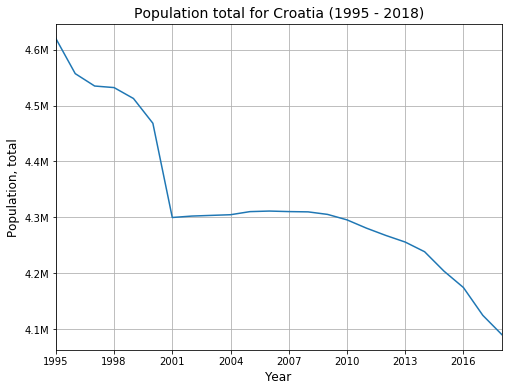

In [44]:
# plt.figure() # create figure

ax = pop_c.plot(kind='line', figsize=(8, 6), legend=False)

ax.set_title ('Population total for Croatia (1995 - 2018)',fontsize=14)
ax.set_ylabel(cols[5],fontsize=12)
ax.set_xlabel('Year',fontsize=12)
ax.grid(True)

# ensure that x-axis have integer-only tick labels
# and increase number of ticks
ax.xaxis.set_major_locator(tkr.MaxNLocator(integer=True))
# reformat tick labels with million's M and comma separator
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: "{:,.1f}M".format(x*1e-6)))

plt.show()
#plt.savefig("./Figures/population_line.png")

### Plot GDP per Capita for Croatia (1995 - 2018)

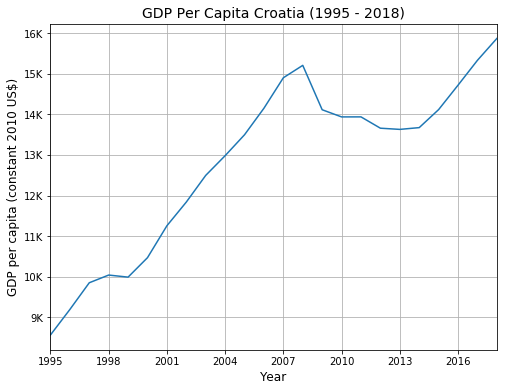

In [45]:
# plt.figure() # create figure

ax = gdp_c.plot(kind='line', figsize=(8, 6), legend=False)

ax.set_title ('GDP Per Capita Croatia (1995 - 2018)',fontsize=14)
ax.set_ylabel(cols[3],fontsize=12)
ax.set_xlabel('Year',fontsize=12)
ax.grid(True)

# ensure that x-axis have integer-only tick labels
# and increase number of ticks
ax.xaxis.set_major_locator(tkr.MaxNLocator(integer=True))
# reformat tick labels with thousand's K and comma separator
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: "{:,.0f}K".format(x*1e-3)))

plt.show()
#plt.savefig("./Figures/GDP_line.png")

**Let's put these two plots together.**

### Plot "Population, total" and GDP per Capita for Croatia (1995 - 2018)

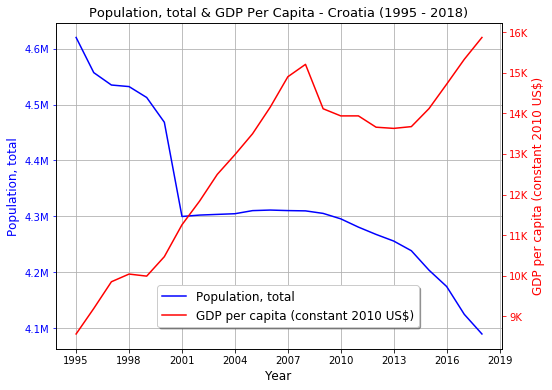

In [46]:
# plot with 2 y-axes
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_title ('Population, total & GDP Per Capita - Croatia (1995 - 2018)', fontsize=13)

y1_label = cols[5]
y2_label = cols[3]

ax.plot('Year', 'PopulationTotal','-b',data=pop_cro, label = y1_label)

ax2 = ax.twinx()
ax2.plot('Year', 'GDPperCapita', '-r', data=gdp_cro, label=y2_label)
fig.legend(loc=8, bbox_to_anchor=(0.5, 0.132), fontsize=12, shadow=True)

ax.grid(True)
ax.set_xlabel('Year', fontsize=12)

# Make the y-axis label, ticks and tick labels match the line color.
ax.set_ylabel(y1_label, color='b', fontsize=12)
ax.tick_params('y', colors='b')
ax2.set_ylabel(y2_label, color='r', fontsize=12)
ax2.tick_params('y', colors='r')

# ensure that x-axis have integer-only tick labels
# and increase number of ticks
ax.xaxis.set_major_locator(tkr.MaxNLocator(integer=True))

# reformat tick labels with million's M and comma separator
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: "{:,.1f}M".format(x*1e-6)))
# reformat tick labels with thousand's K and comma separator
ax2.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: "{:,.0f}K".format(x*1e-3)))

plt.show()
#fig.savefig("./Figures/population_GDP_line.png")

- The Yugoslav wars heavily impacted population of Croatia for almost a decade
- The Great Recession had a smaller but still significant negative impact to both, GDP and population, that lasted for many years
- Croatia joined the EU in 2013 and since then GDP is increasing. At the same time population is declining even faster than before. This is probably due to freedom of movement and residence of persons in the EU.


Let's now check relationship between GDP and population decline.

### Plot and calculate correlation between GDP and total population (1995 - 2018)

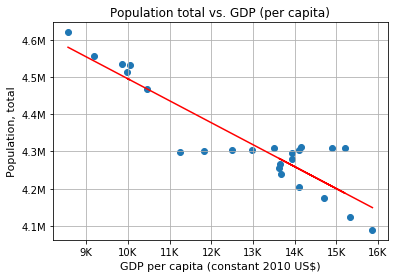

In [47]:
# scatter plot 
fig, ax = plt.subplots()

# Grid lines, Xticks, Xlabel, Ylabel
ax.yaxis.grid(True)
ax.set_title('Population total vs. GDP (per capita)',fontsize=12)
ax.set_xlabel(cols[3],fontsize=11)
ax.set_ylabel(cols[5],fontsize=11)
ax.grid(True)

# reformat tick labels with million's M and comma separator
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: "{:,.1f}M".format(x*1e-6)))
# reformat tick labels with thousand's K and comma separator
ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: "{:,.0f}K".format(x*1e-3)))

X = gdp_cro['GDPperCapita']
Y = pop_cro['PopulationTotal']
ax.scatter(X, Y)

z = np.polyfit(X, Y, 1)
p = np.poly1d(z)
ax.plot(X, p(X),'-r')

plt.show()
#plt.savefig("./Figures/population_GDP_scatter.png")

In [48]:
pop_c.join(gdp_c).head(2)

,Population,GDP
Year,,
1995,4620030.0,8563.04239
1996,4557097.0,9191.21024


In [49]:
# join 2 dataframes and calculate correlation
pop_c.join(gdp_c).corr()

,Population,GDP
Population,1.000000,-0.909188
GDP,-0.909188,1.000000


* There is a negative correlation mostly contributed by steady GDP grow before the Great Recession in 2008 and after the EU integration. 
* During the years after the war, up to 2001, and after the Great Recession, we see population decline. 

### GDP per Capita for Croatia vs. some EU and NA countries (1995 - 2018)

Let's check relationship between GDP for Croatia compared to some EU and North anerica countries.

**Create new dataframe with countries for which we want to compare GDP per Capita**

In [50]:
# create Pandas series of countries
eunac_cntr = pd.Series(['United States','Ireland','Germany','Austria','Canada', 'Croatia'])
eunac_cntr

0    United States
1          Ireland
2          Germany
3          Austria
4           Canada
5          Croatia
dtype: object

In [51]:
# country mask
mask_eunac = data['CountryName'].isin(eunac_cntr)
# new dataframe
eunac= data[mask_eunac].copy()
eunac = eunac[eunac['Year'] >= 1995]
eunac.head(2)

,CountryName,CountryCode,Year,GDP per capita (constant 2010 US$),Net migration,"Population, total"
743,Austria,AUT,1995,36537.993039,NaN,7948278.0
744,Austria,AUT,1996,37346.007435,NaN,7959017.0


In [52]:
# drop not needed columns, keep GDP only
gdp_eunac = eunac.drop(['Net migration','Population, total'],axis=1)
# rename GDP column
gdp_eunac = gdp_eunac.rename(columns={'GDP per capita (constant 2010 US$)':'GDPperCapita'})
gdp_eunac.head(2)

,CountryName,CountryCode,Year,GDPperCapita
743,Austria,AUT,1995,36537.993039
744,Austria,AUT,1996,37346.007435


**Reshape new dataframe to have countries in columns**

In [53]:
# reshape/pivot dataframe
gdp_eunac = gdp_eunac.pivot_table(values='GDPperCapita',columns=('CountryName'),index='Year')
gdp_eunac.head(2)

CountryName,Austria,Canada,Croatia,Germany,Ireland,United States
Year,,,,,,
1995,36537.993039,37600.330122,8563.04239,34782.568625,29694.647007,38369.161843
1996,37346.007435,37811.713235,9191.21024,34965.690886,31644.886087,39356.091800


In [54]:
# Remove column name "CountryName"
gdp_eunac.columns.name = None
# Insert index "Year" as column and reset index to default integer index
gdp_eunac.reset_index(inplace=True)
gdp_eunac.tail(2)

,Year,Austria,Canada,Croatia,Germany,Ireland,United States
22,2017,49190.173414,51150.754621,15331.902482,46987.787982,71755.967008,53356.236236
23,2018,50250.045060,51382.422790,15870.281155,47501.812652,76880.807713,54541.720518


**Plot GDP for all countries in dataframe**

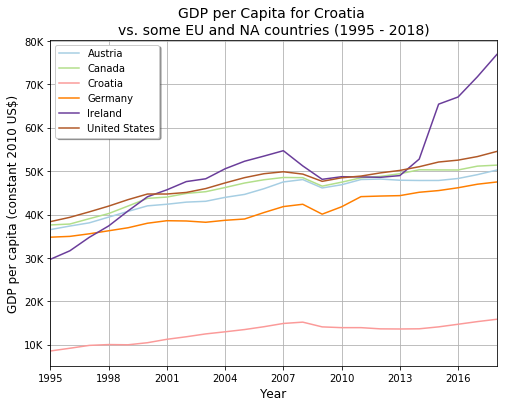

In [55]:
# plt.figure() # create figure

ax = gdp_eunac.plot(x='Year',kind='line',figsize=(8,6),colormap='Paired')
ax.legend(shadow=True)

ax.set_title ('GDP per Capita for Croatia \nvs. some EU and NA countries (1995 - 2018)',fontsize=14)
ax.set_ylabel(cols[3],fontsize=12)
ax.set_xlabel('Year',fontsize=12)

ax.grid(True)

# ensure that x-axis have integer-only tick labels
# and increase number of ticks
ax.xaxis.set_major_locator(tkr.MaxNLocator(integer=True))
# reformat tick labels with thousand's K and comma separator
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: "{:,.0f}K".format(x*1e-3)))

plt.show()
#plt.savefig("./Figures/GDP_line_EU_NA_C.png")

* All countries had a significant deep in GDP after the Great Recession (2008).
* Croatia's GDP fell about 10% following the Great Recession. It completely recovered since 2014 with steady growth of 3% - 4% per year.
* Increasing GDP in Croatia (~\\$16000) is still well below \\$50000 (Austria, Canada, US, Germany) and \\$75000 (Ireland)

**GDP Impact:**

* We can see negative correlation between GDP and population growth for Croatia, but there is no causation
* Looking only at GDP for Croatia, it is hard to believe that people would emigrate when GDP is increasing. There is something else:
 1. Low GDP for Croatia, compared to other listed countries, has probably a huge impact to emigration.
 2. Integration to the EU helped for easy and free move to other EU members


### The final conclusion:

* The Yugoslav wars heavily impacted population of Croatia for almost a decade

* The Great Recession had a smaller but still significant impact that lasted for many years

* I believe from experience that joining EU caused continuous population decline. A significant number of young people is leaving Croatia every year. 

* There is no direct relationship between GDP in Croatia and population decline. 

* Croatia's GDP is steadily increasing since 2014 but GDP in many EU countries is 4 - 5 times higher than Croatia's GDP. This combined with right to move and reside freely throughout the EU is probably the main reason for population decline in the last decade.